In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
%matplotlib inline

First, I'll recopy the NYC crime regression I did a while back...

In [9]:
nyc_crime = pd.read_excel('nyc_crime.xls')
nyc_crime.columns = nyc_crime.iloc[3].rename('')
nyc_crime = nyc_crime.drop(nyc_crime.index[:4])
nyc_crime = nyc_crime.reset_index(drop=True)
nyc_crime.index.name = None
nyc_crime['Murder'] = np.where(nyc_crime['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)
nyc_crime['Robbery2'] = np.where(nyc_crime['Robbery'] > 0, 1, 0)
nyc_crime = nyc_crime.rename(columns = {'Property\ncrime':'Property_Crime', 'Murder and\nnonnegligent\nmanslaughter':'Murder_and_Manslaughter'})
# nyc_crime = nyc_crime[['City','Population', 'Murder','Robbery2','Property\ncrime']]
nyc_crime.head()

,City,Population,Violent crime,Murder_and_Manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property_Crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery2
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0,0,0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0,0,0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0,0,0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN,1,1
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN,0,1


In [10]:
lower_pop = nyc_crime[nyc_crime['Population']<100000]
lower_pop.head()

,City,Population,Violent crime,Murder_and_Manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property_Crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Murder,Robbery2
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0,0,0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0,0,0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0,0,0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN,1,1
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN,0,1


Going to run the regression to predict Property Crime using Population, Murder_and_Manslaughter, and Robbery as continuous data... This one had the highest R-squared score at 81%.

In [12]:
regr = linear_model.LinearRegression()
Y = lower_pop['Property_Crime'].values.reshape(-1, 1)
X = lower_pop[['Population', 'Murder_and_Manslaughter','Robbery']]
Y = Y[:-3]
X = X[:-3]

regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  0.01794989 -11.83371065   6.75533668]]

Intercept: 
 [-6.04558793]

R-squared:
0.810005571783


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Now, I'm going to run the NYC crime data with the same features with a KNN model. The R-squared score is only at 66%.

In [14]:
from sklearn import neighbors

In [18]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = lower_pop['Property_Crime'].values.reshape(-1, 1)
X = lower_pop[['Population', 'Murder_and_Manslaughter','Robbery']]
knn.fit(X, Y)

knn.predict([[75000, 1, 25]])

array([[1724.7]], dtype=object)

In [17]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# score_w = cross_val_score(knn_w, X, Y, cv=5)
# print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.66 (+/- 0.22)


I'm going to try it with just one feature... Just so that I can plot it...

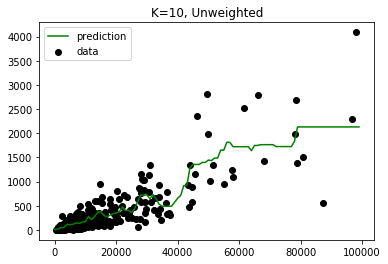

Unweighted Accuracy: 0.66 (+/- 0.24)


In [22]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(lower_pop.Population)
Y = lower_pop.Property_Crime
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 100000, 1000)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Does the +/- 0.24 mean that it's accuracy can either be 90% or 42%?

I tried it again weighted... and the R-squared score was even lower...

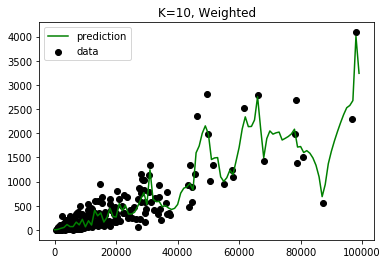

Weighted Accuracy: 0.61 (+/- 0.21)


In [25]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')

X = pd.DataFrame(lower_pop.Population)
Y = lower_pop.Property_Crime

knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 100000, 1000)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

score = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Does the +/- 0.21 mean that it's accuracy can either be 82% or 40%?

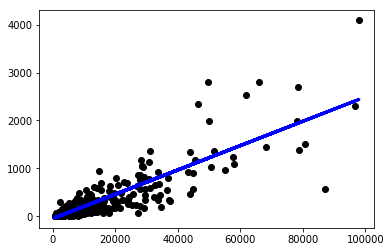


Coefficients: 
 [[ 0.02536236]]

Intercept: 
 [-46.55223753]

R-squared:
0.723970228506


In [27]:
regr = linear_model.LinearRegression()
Y = lower_pop['Property_Crime'].values.reshape(-1, 1)
X = lower_pop[['Population']]
Y = Y[:-3]
X = X[:-3]

regr.fit(X, Y)

plt.scatter(X, Y, color='black')
plt.plot(X, regr.predict(X), color='blue', linewidth=3)
plt.show()

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

Looking at the two plots comparing the weighted KNN vs the OLS regressions, the main difference that the OLS regression is a straight line while the weighted KNN is a scribble. 

I see how the KNN regression would be more useful if the data has a lot of variation and clusters at specific values of the independent variable. A linear regression would miss out on the highs and lows whereas with the KNN you may actually get a more accurate prediction.